### Title: EDA and Feature Engineering  
Author: Yiran Jing

Date: 10-10-2018



##### Dataset Description

**- time period: ** 2016-05-01 - 2017-04-30

**- freq: **30 min (48 records /per day)

**- Explanatory Dependent Variable**

Power demand (half hour/records)

**- Regressor/Exogenous Variable **

1. price
2. weather/Temperature 


In [1]:
from collections import Counter
import pandas as pd
import csv
import pprint
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
from collections import defaultdict
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib as mpl
from pandas import Series
from matplotlib import pyplot
from time_series import ts_plot,ts_plot2,ts_plot3,acf_pacf_plot,hist,modify_time_format,epoch_seconds_to_timestamp
import statsmodels.api as sm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import glob, os
from matplotlib import pyplot as plt
from time_series import difference,first_diff,first_seasonal_diff,seasonal_diff,data_time,data_origin_first_seasonal_firstSeasonal
from time_series import draw_acf_acf,draw_diff_plot,draw_diff_plot
from time_series import plot_regressions,plot_time_decomposition,time_series_SA,time_series_weather_SA,group_holiday_plot,bonxcox_transf

In [2]:
power_old = pd.read_csv('../data/demand_temp_price.csv',)
# power.head()

## 1. EDA
- non-parametric regression
- time decomposition
- complexity seasonality plots
- weather time series plot (price and demand shown in Feature engineering part1)

#### 1.1 Local linear regression
Non-parametric / Kernel regression

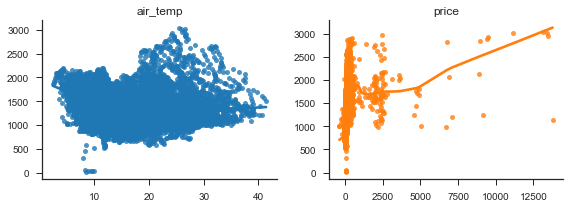

In [3]:
X = power_old.loc[:,["air_temp", "price"]]
y = power_old['demand']
plot_regressions(X, y)  # see pacakge, set lowess = True already
plt.show()

Clearly, no linear relationship exists. Tried log/box-cox transformation, unhelpful

So, we use original data, but definitely, non-linnear model shall be better

#### 1.2 Time decomposition 


- High degree of seasonality here.
- The seasonal variation seems not proportional to the trend, therefore we use the **additive model**
- The trend of demand is simlar with temperature **Possible spurious relationship**, so we need trend variable!
- No trend in price, but **Outlier** shown, so no whhte noise! **classical model , change them by hand?**

Thus, for classical model, 


For advanced model (like Bayesian NN), we shall add dummy for outlier, and dummy for seasonnality (see complexity seasoality plots below):
1. in-day seasonality dummy
2. in-week seasonality dummy


🙂 Plot from 2016-05-01 00:30:00 to 2017-04-30 14:00:00


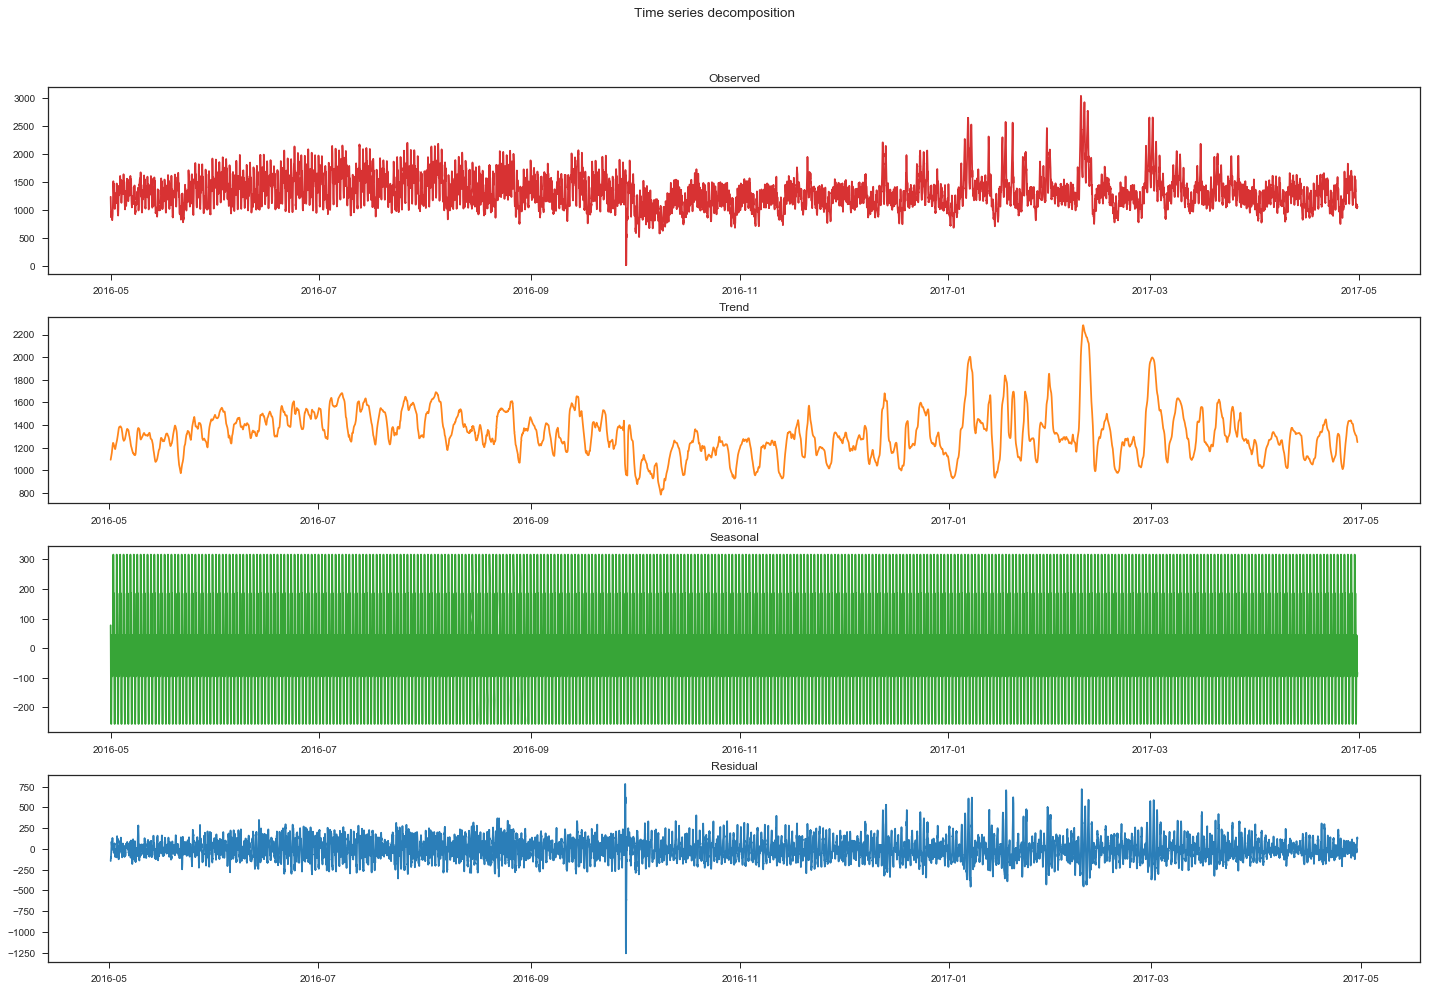

In [4]:
plot_time_decomposition(power_old, 75000,'demand', 48, 'additive')


🙂 Plot from 2017-03-09 12:30:00 to 2017-04-30 14:00:00


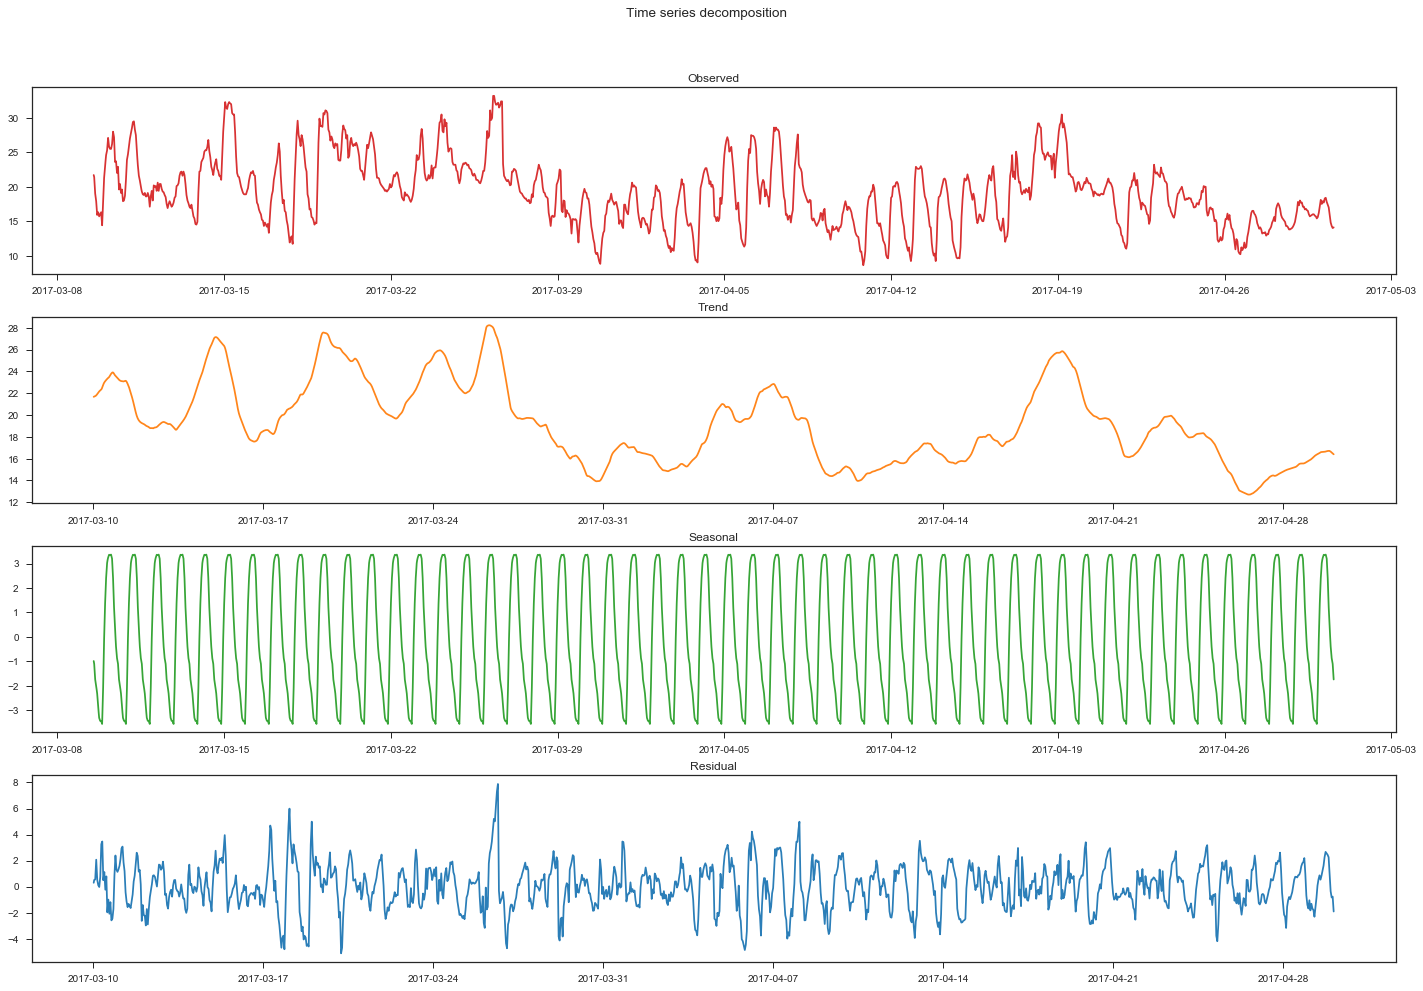

In [5]:
plot_time_decomposition(power_old, 2500,'air_temp', 48, 'additive')


🙂 Plot from 2017-03-09 12:30:00 to 2017-04-30 14:00:00


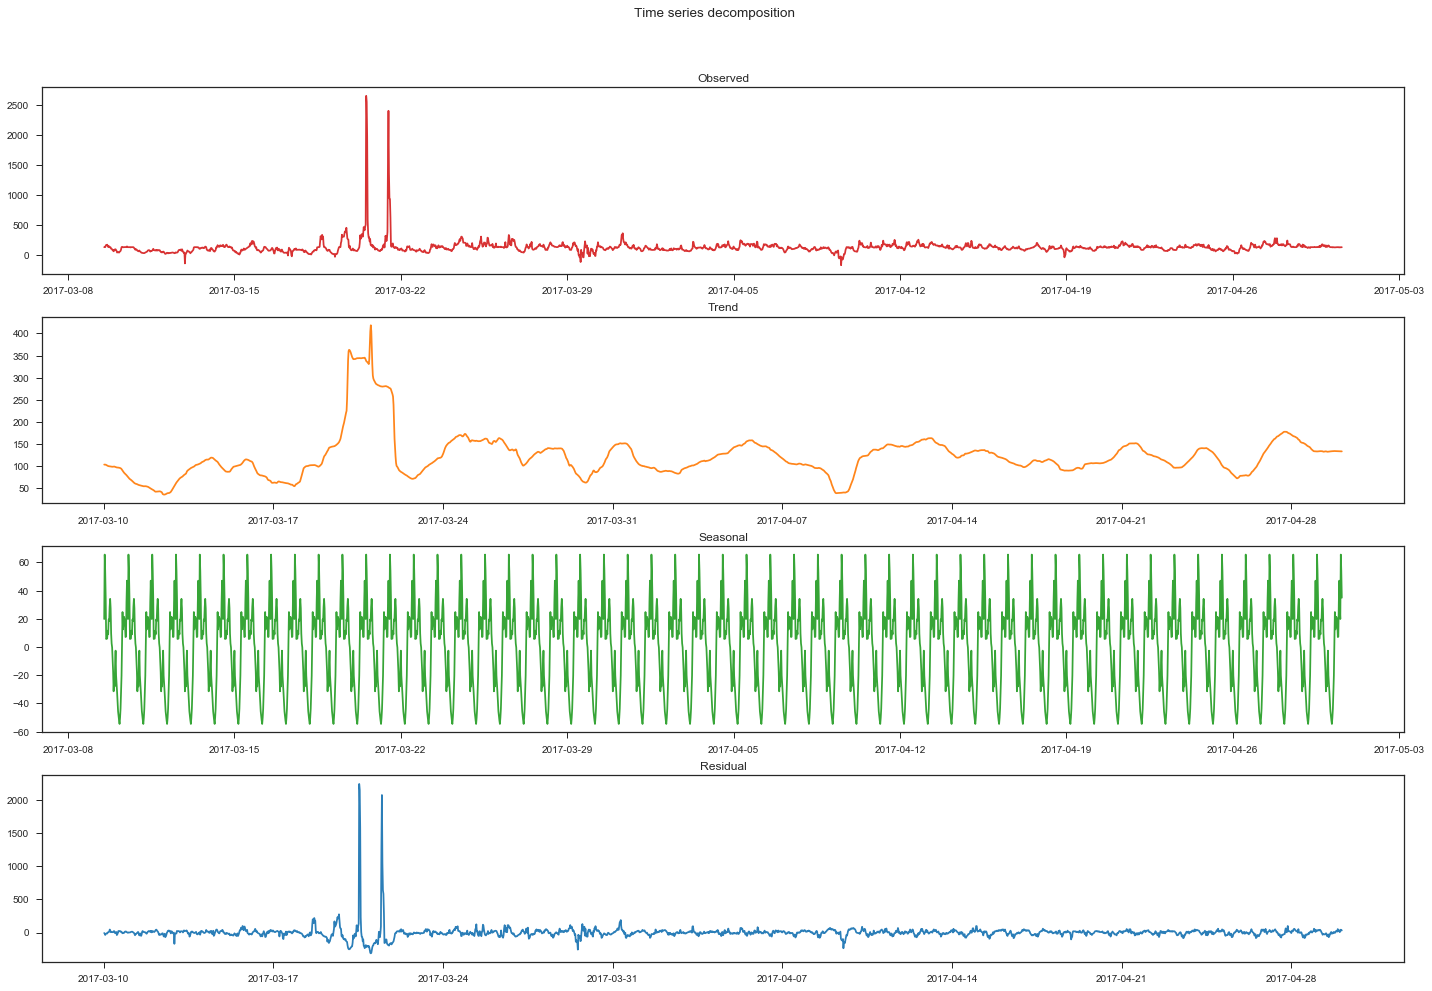

In [6]:
plot_time_decomposition(power_old, 2500,'price', 48, 'additive')

Thus, we need clear data of price (remove outlier)

See feature engineering part 1

#### 1.3 complexity seasonality plots
In R notebook

#### 1.4 weather time-series plot


- Reseach information

Primary use for power is for heating and cooling (40%) houses. The secondary driver for residential energy consumption is water heating (23%). Hence our hypothesis is that changes in temperature are a good predictor for energy use. 
**higher variation in summer temperature**. 
However South Australia has a far higher variation in summer temperature causing ‘very large variations in daily energy consumption and even larger variation in daily peaks’ (Saddler, 2013) . 
In most of South Australia temperatures of over 40 degrees were recorded with the maximum being 48.2 degrees on the 9th of February at Tarcoola 

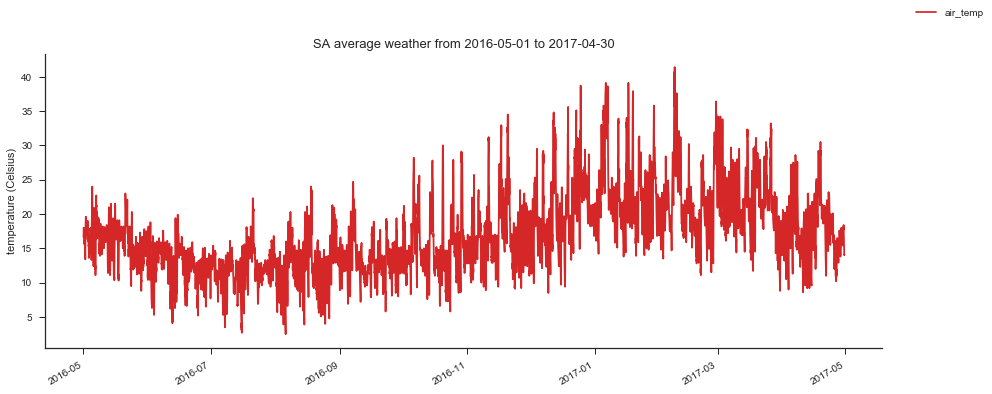

In [7]:
time_series_weather_SA('SA average weather from 2016-05-01 to 2017-04-30',power_old)

## 2. Feature Engineering
- clear data (replace price if more than 400)
- Add dummy variable for Special events (Blackout/Heatwaves)
- check holiday for dummy
- clean data for outlier (price)

- stationary check and transformation
  - detrand stationary
  - difference stationary

#### 2.1 Add dummy variable for Blackout/Heatwaves

Based on reasearch infor and plot below, add two kinds of dummy: 

** dummy_Balckout **
quite low demand, price stable

- 28th of September


** dummy_HeatWaves ** high demand, high price 

- 9-14th January 2017
- 17-21st January 2017
- 31st Jan – 12th Feb 2017


☹️ Blackout:

28th of September 2016 South Australian Blackout
27th of December 2016, caused by storm damage.
8th of February 2017 caused by excess load shedding during a major heatwave.

🔥🔥 Heatwaves in South Australia

The three major events occurred between:
1. 9-14th January 2017
2. 17-21st January 2017
3. 31st Jan – 12th Feb 2017




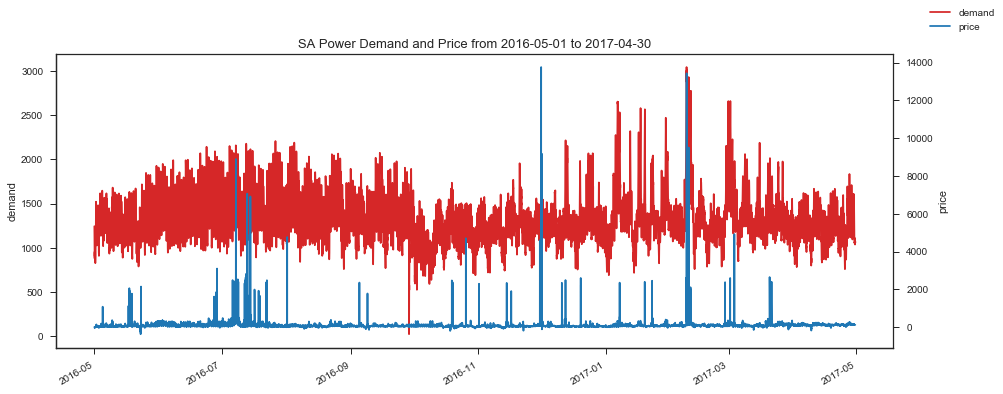

In [12]:
time_series_SA('SA Power Demand and Price from 2016-05-01 to 2017-04-30', power_old)

####  2.2 No dummy variable needed for public holiday

decison based on: 

- data plot

based on the plot below,during some holiday, the demand is quite low

- research info

Primary use for power is for heating and cooling (40%) houses. And research shows the evidence that energy consumption is lowest on holidays, such as Christmas. 

** based on plot below, I donot think dummy for public holiday needed** (run it if you want to see)

In [ ]:
group_holiday_plot(power, 'Power Demand and Price')

### 2.3 stationary check and transformation

##### Conclustion:
Demand and Tem need first and seaseaonal difference, temp just need first difference

##### Process: 
1. ACF/PACF,  
2. First order difference and Seasonal difference decision
3. Dickey fuller test for stationary state



### 2.3 Detrend data
- spruious relationship

(*Finding a signficant relationship betwee 2 time series variables when in fact there is no relationship between them!*)

Because the trends of power demand and temperature are quite similar, we may find **spruious relationship** between these two **trend data**. 

In order to cature the true relationships bewteen regressors and dependent variable, we can add **trend variable (t)** in order to help control for case in which any of the variables in the model are **linearly trending**

#### 2.3.1  ACF/PACF for origion data
Origial time series for three variable

The slow-decaying ACF implies **high persistent** data, thus is the singal of non-stationary

 I am detrend_demand! 


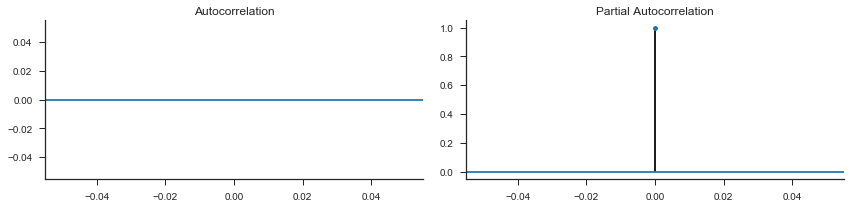

 I am price! 


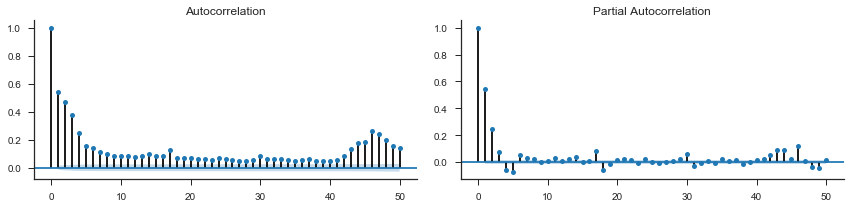

 I am detrend_air_temp! 


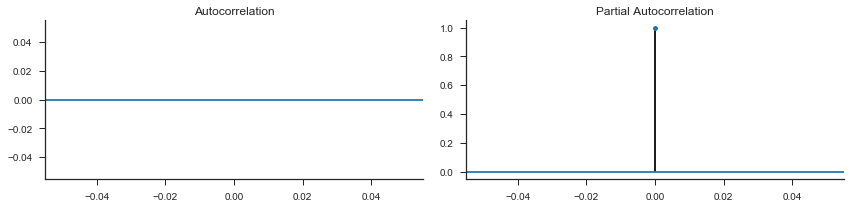

In [15]:
power = power_old
check = ['detrend_demand','price','detrend_air_temp']
draw_acf_acf(check, power)

non-stationary data! 

let's do difference!

#### 2.3.2-3 First order difference and Seasonal difference decision
Based on plot below, 

**- Demand and Tem need first and seaseaonal difference**

**- price just need first difference**

In [ ]:
# demand
diffed_dataset1 = data_origin_first_seasonal_firstSeasonal(power,48,'detrend_demand')
draw_diff_plot(diffed_dataset1)

In [ ]:
# price
diffed_dataset2 = data_origin_first_seasonal_firstSeasonal(power,48,'price')
draw_diff_plot(diffed_dataset2)

/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


In [ ]:
# air_temp
diffed_dataset = data_origin_first_seasonal_firstSeasonal(power,48,'detrend_air_temp')
draw_diff_plot(diffed_dataset) 

###### Generate stationary dataset

In [ ]:
diffed_dataset1.head()

In [ ]:
diffed_dataset1 = data_origin_first_seasonal_firstSeasonal(power,48,'detrend_demand')
diffed_dataset2 = data_origin_first_seasonal_firstSeasonal(power,0,'price')
diffed_dataset = data_origin_first_seasonal_firstSeasonal(power,48,'detrend_air_temp')

In [ ]:
dataset_final = pd.DataFrame()
dataset_final['period'] = diffed_dataset1.index
dataset_final['demand'] = diffed_dataset1['first_season_diff']
dataset_final['price'] = diffed_dataset2['first_diff']
dataset_final['air_temp'] = diffed_dataset['first_season_diff']

In [ ]:
final_trans = pd.DataFrame()
final_trans["demand"] = diffed_dataset1.first_season_diff
final_trans["price"] = diffed_dataset2.first_diff
final_trans["air_temp"] = diffed_dataset.first_season_diff
final_trans["period"] = diffed_dataset1.index